In [1]:
import os
import re
import json
import base64
import shutil
import urllib
import hashlib
from io import BytesIO

import requests

from diffusers import StableDiffusionImg2ImgPipeline
import torch
from PIL import Image
from lora_diffusion import patch_pipe, tune_lora_scale

/Users/bohuiwu/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cpu'
protocol = 'http'
host = '127.0.0.1'
port = '80'
origin = f'{protocol}://{host}:{port}'
api_endpoint = f'{origin}/api/v1/queue/task'
print(f'Using API: {api_endpoint}')

Using API: http://127.0.0.1:80/api/v1/queue/task


In [3]:
def get_queue_task():
    response = requests.get(f"{api_endpoint}?" + urllib.parse.urlencode({
        'action': 'fetch_task',
        'task_types': '1,2'
    }))

    if response.status_code == 200:
        json_response = response.json()
        return json_response
    else:
        print(f"Error: Request returned status code {response.status_code} with message {response.content}")
        return None


def get_task_lora_model(access_key):
    response = requests.get(f"{api_endpoint}?" + urllib.parse.urlencode({
        'action': 'fetch_model',
        'access_key': access_key,
    }))

    if response.status_code == 200:
        json_response = response.json()
        return json_response
    else:
        print(f"Error: Request returned status code {response.status_code} with message {response.content}")
        return None

In [4]:
# Notify the master nodes
def send_task_queue_update(task_id, access_key, actions):
    headers = {'Content-Type': 'application/json'}
    body = {
        'task_id': task_id,
        'access_key': access_key,
        'actions': actions
    }
    response = requests.post(api_endpoint, data=json.dumps(body), headers=headers)

    if response.status_code == 200:
        json_response = response.json()
        return json_response
    else:
        print(f"Error: Request returned status code {response.status_code} with message {response.content}")
        return None

In [5]:
queue_task = get_queue_task()


{'task': {'task_id': 6,
  'task_type': 2,
  'task_parameters': '{"model_name": "public/lora_disney", "prompt": "a plane", "seed": "2", "lora_alpha": "1", "num_steps": "25", "cfg_scale": "7.5"}',
  'obj': '',
  'model_md5': '347139332d073df41e5dac3a8aad2595'},
 'access_key': 'a3a6088544a14d62a97a01e976f6a9b4'}
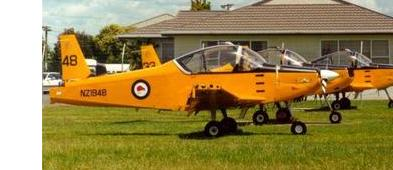

In [6]:
queue_task

In [7]:
access_key = queue_task['access_key']
base64_arr = queue_task['task']['obj'].split('\n')
task_id = queue_task['task']['task_id']
input_path = os.path.join('.', 'temp', str(task_id))
# Recreate the folder
if os.path.exists(input_path):
    shutil.rmtree(input_path)
os.makedirs(input_path)
for index, base64_str in enumerate(base64_arr):
    if len(base64_str) == 0:
        continue
    meta_info, base64_img = base64_str.split(',')
    file_extension = re.search(r'(?<=/)[a-zA-Z0-9]+(?=;)', meta_info).group()
    filename = f'{index}.{file_extension}'
    img_path = os.path.join(input_path, filename)
    with open(img_path, 'wb') as f:
        f.write(base64.b64decode((base64_img)))

In [8]:
task_params = json.loads(queue_task['task']['task_parameters'])
if queue_task['task']['task_type'] == 1:
    task_params['num_steps'] = 1

    output_dir = f'./output/{task_id}'
    
    # Update server
    send_task_queue_update(task_id, access_key, [
        {
            'action': 'log',
            'content': f'Training mode {task_params["model_name"]}...'
        }
    ])
    
    
    from lora_diffusion.cli_lora_pti import train as train_lora
    train_lora(pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5", \
           instance_data_dir=input_path, output_dir=output_dir, \
           train_text_encoder=True, resolution=int(task_params['resolution']), \
           train_batch_size=1, gradient_accumulation_steps=int(task_params['num_gradient_accumulation']), \
           scale_lr=True, learning_rate_unet=1e-4, learning_rate_text=1e-5, learning_rate_ti=5e-4, \
           color_jitter=True, lr_scheduler='linear', lr_warmup_steps=0, placeholder_tokens="<s1>|<s2>", \
           use_template='style', save_steps=100, max_train_steps_ti=int(task_params['num_steps']), \
           max_train_steps_tuning=int(task_params['num_steps']), perform_inversion=True, clip_ti_decay=True, \
           weight_decay_ti=0.000, weight_decay_lora=0.001, continue_inversion=True, continue_inversion_lr=1e-4, \
           device=device, lora_rank=1)
    
    # Orignal location
    lora_output_model_path = os.path.join(os.path.join(output_dir, 'final_lora.safetensors'))

    # Get file md5
    with open(lora_output_model_path, 'rb') as f:
        file_data = f.read()
        md5_hash = hashlib.md5(file_data).hexdigest()
        model_base64_encoded = base64.b64encode(file_data).decode('utf-8')

    # Destination
    user_model_base_dir = os.path.join('.', 'user_models')
    if not os.path.exists(user_model_base_dir):
        os.makedirs(user_model_base_dir)
    user_model_path = os.path.join(user_model_base_dir, f'{md5_hash}.safetensors')
    shutil.move(lora_output_model_path, user_model_path)

    # Remove the original path
    os.rmdir(output_dir)
    
    send_task_queue_update(task_id, access_key, [
        {
            'action': 'log',
            'content': 'Model trained successfully.'
        },
        {
            'action': 'update_status',
            'content': 2
        },
        {
            'action': 'save_model',
            'content': model_base64_encoded,
            'md5': md5_hash
        },
        {
            'action': 'finish',
        }
    ])


In [9]:
if queue_task['task']['task_type'] == 2:
    model_md5 = queue_task['task']['model_md5']
    lora_model_base_path = os.path.join('.', 'temp', 'models')
    if not os.path.exists(lora_model_base_path):
        os.makedirs(lora_model_base_path)
    lora_model_path = os.path.join(lora_model_base_path, f'{model_md5}.safetensors')
    if not os.path.exists(lora_model_path):
        res = get_task_lora_model(access_key=access_key)
        model_data = res['model_data']
        with open(lora_model_path, 'wb') as f:
            f.write(base64.b64decode((model_data)))
        with open(lora_model_path, 'rb') as f:
            model_data = f.read()
            downloaded_model_md5_hash = hashlib.md5(model_data).hexdigest()
            if downloaded_model_md5_hash != model_md5:
                send_task_queue_update(task_id, access_key, [
                    {
                        'action': 'error',
                        'content': 'Mismatch MD5 found.'
                    }
                ])
                os.remove(lora_model_path)
                # TODO: Stop here
    input_image = Image.open(img_path).convert("RGB").resize((512, 512))

    model_id = "runwayml/stable-diffusion-v1-5"
    pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, torch_dtype=torch.float16 if device != 'cpu' else torch.float32).to(device)
    patch_pipe(pipe, lora_model_path, patch_text=True, patch_unet=True, patch_ti=True)

    prompt = f"style of <s1><s2>, {task_params['prompt']}"
    prompt = "style of <s1><s2>, robotic horse with rocket launcher"
    
    torch.manual_seed(1)
    tune_lora_scale(pipe.unet, 0.7)
    tune_lora_scale(pipe.text_encoder, 0.3)

    output_image = pipe(prompt=prompt, image=input_image, strength=0.75, guidance_scale=7.5).images[0]
    
    # Convert to bytes using a BytesIO buffer
    buffered = BytesIO()
    output_image.save(buffered, format="JPEG")
    output_images_bytes = buffered.getvalue()

    # Encode the bytes as base64
    output_image_base64_encoded = base64.b64encode(output_images_bytes).decode('utf-8')

    # Hash value
    output_image_md5_hash = hashlib.md5(output_images_bytes).hexdigest()

    actions = [
        {
            'action': 'log',
            'content': f'Inferece on model {task_params["model_name"]} executed successfully.'
        },
        {
            'action': 'update_status',
            'content': 2
        },
        {
            'action': 'set_output_image',
            'content': output_image_base64_encoded,
            'extension': 'jpg',
            'md5': output_image_md5_hash
        },
        {
            'action': 'finish',
        }
    ]
    send_task_queue_update(task_id, access_key, actions)

Fetching 15 files: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 119156.36it/s]
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/Users/bohuiwu/Library/Python/3.9/lib/python/site-packages/transformers/modeling_utils.py:402: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  with safe_open(checkpoint_file, framework="pt") as f:
/Users/bohuiwu/Library/Python/3.9/lib/python/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the 

<s1>
<s2>


100%|██████████████████████████████████████████████████████████████████████████████| 37/37 [04:34<00:00,  7.42s/it]
